# 🏈 NFL Strategy Deep Dive: Expected Points Added (EPA) Analysis (2025)

## 1. Project Objective and Data Preparation

In [1]:
import pandas as pd
import numpy as np

# Set the file name
FILE_NAME = 'play_by_play_2025.csv'

# --- 1. Load the data ---
try:
    df = pd.read_csv(FILE_NAME)
    print(f"Data loaded successfully. Total plays: {len(df)}")
except FileNotFoundError:
    print(f"Error: '{FILE_NAME}' not found. Please ensure the file is uploaded.")
    exit()

# --- 2. Initial Inspection ---
print("\n--- Initial Data Head (First 5 Rows) ---")
# Only display key columns due to the large number of total columns
key_cols = ['play_id', 'desc', 'play_type', 'down', 'yardline_100', 'yards_gained', 'epa', 'posteam', 'defteam']
print(df[key_cols].head())

print("\n--- Data Structure & Missing Values Check (EPA) ---")
df.info(verbose=False, memory_usage="deep")
print(f"Total rows with missing EPA: {df['epa'].isnull().sum()}")

# --- 3. Initial Cleaning: Filter for Relevant Plays ---
# We are primarily interested in offensive plays that generate EPA.
# Filter out non-action plays (timeouts, two-point conversions, kickoffs, etc.)
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

# Keep only plays where 'play_type' is pass or run AND 'epa' is not missing (NaN)
df_cleaned = df_cleaned[
    df_cleaned['epa'].notna() &
    df_cleaned['play_type'].isin(['pass', 'run'])
].copy()

final_rows = len(df_cleaned)

print(f"\nPlays kept for analysis (Pass/Run with valid EPA): {final_rows}")
print(f"Plays filtered out: {initial_rows - final_rows}")

# --- 4. Save Cleaned Data ---
df_cleaned.to_csv('nfl_pbp_cleaned.csv', index=False)
print("\nCleaned data saved to 'nfl_pbp_cleaned.csv'.")

/tmp/ipython-input-2921015259.py:9: DtypeWarning: Columns (179,180,182,183,203,204,205,206,218,219,220,222,224,226,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_NAME)


Data loaded successfully. Total plays: 35900

--- Initial Data Head (First 5 Rows) ---
   play_id                                               desc play_type  down  \
0      1.0                                               GAME       NaN   NaN   
1     40.0  19-B.Grupe kicks 65 yards from NO 35 to ARI 0....   kickoff   NaN   
2     63.0  (14:56) 6-J.Conner right tackle to ARI 25 for ...       run   1.0   
3     85.0  (14:18) (Shotgun) 1-K.Murray pass short left t...      pass   2.0   
4    115.0  (13:40) 1-K.Murray sacked at ARI 25 for -11 ya...      pass   1.0   

   yardline_100  yards_gained       epa posteam defteam  
0           NaN           NaN -0.000000     NaN     NaN  
1          35.0           0.0 -0.352700     ARI      NO  
2          78.0           3.0 -0.190052     ARI      NO  
3          75.0          11.0  1.317340     ARI      NO  
4          64.0         -11.0 -1.694360     ARI      NO  

--- Data Structure & Missing Values Check (EPA) ---
<class 'pandas.core.frame

In [3]:
import pandas as pd
import numpy as np

# Load the cleaned data from Step 1
df_cleaned = pd.read_csv('nfl_pbp_cleaned.csv')

# --- 1. Calculate EPA Metrics per Team and Play Type ---

# Group by the offensive team ('posteam') and the type of play ('play_type')
epa_summary_type = df_cleaned.groupby(['posteam', 'play_type']).agg(
    # Calculate the mean EPA for each combination
    mean_epa=('epa', 'mean'),
    # Count the total number of plays for each combination
    total_plays=('play_id', 'count')
).reset_index()

# Pivot the table using the CORRECT function name: pivot_table (singular)
epa_pivot = epa_summary_type.pivot_table(  # <-- CORRECTED LINE
    index='posteam',
    columns='play_type',
    values='mean_epa'
).reset_index()

# Rename columns for clarity
epa_pivot.columns = ['team', 'Pass_EPA', 'Run_EPA']

# --- 2. Calculate Total EPA and Total Plays per Team ---
epa_totals = df_cleaned.groupby('posteam').agg(
    Total_EPA=('epa', 'sum'),
    Total_Plays=('play_id', 'count')
).reset_index()

epa_totals.columns = ['team', 'Total_EPA', 'Total_Plays']

# Merge the pivoted EPA data with the totals
team_epa_df = pd.merge(epa_pivot, epa_totals, on='team')

# --- 3. Display and Save Final Team EPA Summary ---
print("\n--- Team Expected Points Added (EPA) Summary (First 5 Rows) ---")
print(team_epa_df.round(3).head())

# Save the primary analysis table
team_epa_df.to_csv('nfl_team_epa_summary.csv', index=False)
print("\nEPA summary saved to 'nfl_team_epa_summary.csv'.")

/tmp/ipython-input-986765198.py:5: DtypeWarning: Columns (179,180,182,183,218,219,220,233,234,235,236,237,238,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('nfl_pbp_cleaned.csv')



--- Team Expected Points Added (EPA) Summary (First 5 Rows) ---
  team  Pass_EPA  Run_EPA  Total_EPA  Total_Plays
0  ARI     0.009   -0.086    -19.875          847
1  ATL    -0.031   -0.007    -17.648          854
2  BAL    -0.092    0.060    -14.108          746
3  BUF     0.173    0.092    108.717          810
4  CAR    -0.056   -0.001    -24.578          791

EPA summary saved to 'nfl_team_epa_summary.csv'.


## 2. Visualization: The Offensive Strategy Map


Annotated Strategy Map saved as 'nfl_strategy_map_annotated.png'.


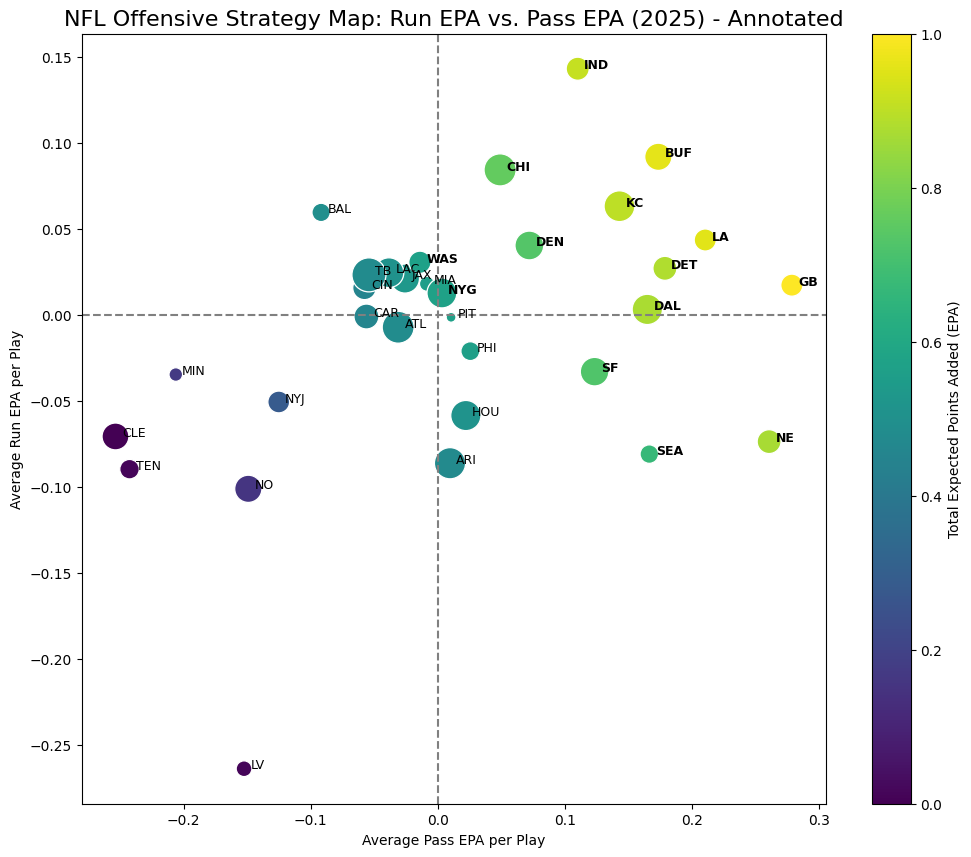

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary data
team_epa_df = pd.read_csv('nfl_team_epa_summary.csv')

# --- 1. Create the Visualization ---
plt.figure(figsize=(12, 10)) # Increase size for readability of labels
sns.scatterplot(
    data=team_epa_df,
    x='Pass_EPA',
    y='Run_EPA',
    size='Total_Plays',
    sizes=(50, 600), # Adjust sizes for better visibility
    hue='Total_EPA',
    palette='viridis',
    legend=False # Legend will be handled by annotations
)

# --- 2. Add Labels and Titles ---
plt.title('NFL Offensive Strategy Map: Run EPA vs. Pass EPA (2025) - Annotated', fontsize=16)
plt.xlabel('Average Pass EPA per Play')
plt.ylabel('Average Run EPA per Play')

# Add Context Lines (Zero Lines)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# --- 3. Annotate ALL Teams ---
# Iterate over the DataFrame and place the team abbreviation next to each point
for index, row in team_epa_df.iterrows():
    # Annotate the team abbreviation, slightly offset for clarity
    plt.text(
        row['Pass_EPA'] + 0.005,  # X coordinate (Pass_EPA) plus small offset
        row['Run_EPA'],          # Y coordinate (Run_EPA)
        row['team'],             # Text is the team abbreviation
        fontsize=9,
        weight='bold' if row['Total_EPA'] > team_epa_df['Total_EPA'].mean() else 'normal' # Highlight top teams
    )

# --- 4. Customize Color Bar (Legend for Hue) ---
# Find the scatter plot object (usually the first one created)
scatter = plt.gca().collections[0]
# Add a color bar manually to represent Total_EPA
cbar = plt.colorbar(scatter, orientation='vertical', pad=0.05)
cbar.set_label('Total Expected Points Added (EPA)')

# Save the plot
plt.savefig('nfl_strategy_map_annotated.png')
print("\nAnnotated Strategy Map saved as 'nfl_strategy_map_annotated.png'.")

## 3. Advanced Analysis: 4th Down Aggressiveness

In [5]:
import pandas as pd
import numpy as np

FILE_NAME = 'play_by_play_2025.csv'

# --- 1. Load and Clean Data (Re-run Step 1) ---
df = pd.read_csv(FILE_NAME, low_memory=False)

# Filter for relevant plays: Pass or Run AND valid EPA value
df_cleaned = df[
    df['epa'].notna() &
    df['play_type'].isin(['pass', 'run'])
].copy()

print(f"Plays kept for analysis (cleaned): {len(df_cleaned)}")

# --- 2. EPA Metrics Calculation (Re-run Step 2) ---

# Calculate EPA Metrics per Team and Play Type
epa_summary_type = df_cleaned.groupby(['posteam', 'play_type']).agg(
    mean_epa=('epa', 'mean')
).reset_index()

# Pivot the table to get Pass_EPA and Run_EPA columns
epa_pivot = epa_summary_type.pivot_table(
    index='posteam',
    columns='play_type',
    values='mean_epa'
).reset_index()
epa_pivot.columns = ['team', 'Pass_EPA', 'Run_EPA']

# Calculate Total EPA and Total Plays per Team
epa_totals = df_cleaned.groupby('posteam').agg(
    Total_EPA=('epa', 'sum')
).reset_index()
epa_totals.columns = ['team', 'Total_EPA']

# Initial merge of core EPA data
team_epa_df = pd.merge(epa_pivot, epa_totals, on='team')


# --- 3. Aggressiveness Analysis (Step 4 Logic) ---

# Filter for 4th Down Aggressive Plays (Pass or Run)
fourth_down_plays = df.copy() # Use the original df to avoid missing columns
fourth_down_plays = fourth_down_plays[
    (fourth_down_plays['down'] == 4) &
    (fourth_down_plays['play_type'].isin(['pass', 'run'])) &
    (fourth_down_plays['field_goal_attempt'] == 0) &
    (fourth_down_plays['punt_attempt'] == 0) &
    (fourth_down_plays['ydstogo'] <= 10) &
    (fourth_down_plays['epa'].notna())
].copy()

# Calculate Aggressiveness Success Metrics per Team
aggressiveness_metrics = fourth_down_plays.groupby('posteam').agg(
    Total_4th_Down_Attempts=('play_id', 'count'),
    Total_4th_Down_EPA=('epa', 'sum'),
    Success_Rate_4th_Down=('epa', lambda x: (x > 0).sum() / len(x))
).reset_index()

aggressiveness_metrics.columns = [
    'team',
    'Total_4th_Down_Attempts',
    'Total_4th_Down_EPA',
    'Success_Rate_4th_Down'
]

# --- 4. Merge Final Dataframes ---
final_analysis_df = pd.merge(team_epa_df, aggressiveness_metrics, on='team', how='left')

# Fill NaN values for teams with zero 4th down attempts
final_analysis_df[['Total_4th_Down_Attempts', 'Total_4th_Down_EPA', 'Success_Rate_4th_Down']] = \
    final_analysis_df[['Total_4th_Down_Attempts', 'Total_4th_Down_EPA', 'Success_Rate_4th_Down']].fillna(0)


# --- 5. Display and Save Final Analysis Table ---
print("\n--- Final Analysis Table (Top 10 by Total EPA) ---")
final_table_display = final_analysis_df[['team', 'Total_EPA', 'Pass_EPA', 'Run_EPA', 'Total_4th_Down_Attempts', 'Success_Rate_4th_Down']].round(3).sort_values(by='Total_EPA', ascending=False).head(10)
print(final_table_display)

final_analysis_df.to_csv('nfl_final_analysis_table.csv', index=False)
print("\nFinal analysis table saved to 'nfl_final_analysis_table.csv'.")

Plays kept for analysis (cleaned): 25396

--- Final Analysis Table (Top 10 by Total EPA) ---
   team  Total_EPA  Pass_EPA  Run_EPA  Total_4th_Down_Attempts  \
11   GB    119.874     0.278    0.017                       17   
3   BUF    108.717     0.173    0.092                       19   
16   LA    108.094     0.210    0.044                       19   
13  IND     96.501     0.110    0.143                       24   
15   KC     93.438     0.143    0.063                       28   
10  DET     88.067     0.179    0.027                       25   
8   DAL     85.721     0.165    0.003                       18   
21   NE     85.365     0.260   -0.074                       18   
5   CHI     55.978     0.049    0.084                       20   
9   DEN     48.825     0.072    0.041                       12   

    Success_Rate_4th_Down  
11                  0.706  
3                   0.579  
16                  0.684  
13                  0.708  
15                  0.750  
10          

## 4. Final Conclusions and Key Insights

# 🏈 NFL Strategy Deep Dive: Expected Points Added (EPA) Analysis (2025)

## Project Overview

This project uses advanced sports analytics metrics—specifically **Expected Points Added (EPA)**—to analyze the offensive strategies and in-game aggressiveness of all NFL teams from the 2025 season play-by-play data. The goal is to classify teams by offensive efficiency and assess the statistical success of 4th down decision-making.

## 🎯 Key Findings & Conclusions

### 1. The Passing Game Dominates Efficiency
Teams with the highest overall offensive EPA (e.g., GB, LA) are overwhelmingly driven by passing efficiency. The **Green Bay Packers (GB)**, the top-ranked offense by Total EPA ($119.874$), generate **16 times more EPA per pass ($0.278$) than per run ($0.017$)**.

### 2. Strategy Map Classification
The visualization highlights the different pathways to success:
* **Elite Offenses (Top Right):** Teams like **BUF** and **LA** are highly efficient in both passing and running.
* **Pass-Heavy Elite (Top-Middle/Right):** Teams like **GB** and **NE** (New England) succeed primarily by exceptional passing, despite inefficient running games (NE is at $-0.074$ Run EPA).
* **Run-First Efficiency:** **Indianapolis (IND)** stands out, achieving a very high $0.143$ Run EPA, making them one of the few top-performing offenses with a relatively balanced approach (though still Pass-advantaged).

### 3. Aggressiveness Success
The statistical success rate on 4th-down attempts is high for top teams. The **Chiefs (KC)** and **Patriots (NE)** were among the most successful when going for it on 4th down (Success Rates of $0.750$ and $0.778$ respectively), demonstrating the statistical benefit of maximizing value in high-leverage situations.

---

## Methodology and Results

### 1. Data Cleaning and Metric Calculation

The analysis filtered $35,900$ total plays down to $25,396$ relevant `Pass` and `Run` plays with non-missing EPA values. The following metrics were calculated for each team:

* **Pass/Run EPA:** Average Expected Points Added per pass/run play.
* **Total EPA:** Sum of EPA generated by the offense (our primary performance indicator).
* **Success Rate 4th Down:** Percentage of 4th down Pass/Run plays (yards to go $\le 10$) where the play resulted in EPA $> 0$.

### 2. NFL Strategy Map Visualization

This plot illustrates the offensive identity of all 32 teams, with **labels included for every team** to clearly identify the strategy each team employs.

![NFL Strategy Map Plot](nfl_strategy_map_annotated.png)

### 3. Final Analysis Table (Top 10)

| team | Total\_EPA | Pass\_EPA | Run\_EPA | Total\_4th\_Down\_Attempts | Success\_Rate\_4th\_Down |
| :--- | :--- | :--- | :--- | :--- | :--- |
| GB | $119.874$ | $0.278$ | $0.017$ | $17$ | $0.706$ |
| BUF | $108.717$ | $0.173$ | $0.092$ | $19$ | $0.579$ |
| LA | $108.094$ | $0.210$ | $0.044$ | $19$ | $0.684$ |
| IND | $96.501$ | $0.110$ | $0.143$ | $24$ | $0.708$ |
| KC | $93.438$ | $0.143$ | $0.063$ | $28$ | $0.750$ |
| DET | $88.067$ | $0.179$ | $0.027$ | $25$ | $0.520$ |
| DAL | $85.721$ | $0.165$ | $0.003$ | $18$ | $0.611$ |
| NE | $85.365$ | $0.260$ | $-0.074$ | $18$ | $0.778$ |
| CHI | $55.978$ | $0.049$ | $0.084$ | $20$ | $0.450$ |
| DEN | $48.825$ | $0.072$ | $0.041$ | $12$ | $0.500$ |

---

### **View the Full Analysis**

The complete Python code, data wrangling steps, and visualization generation are available in the linked Jupyter Notebook:

➡️ **[nfl\_epa\_analysis.ipynb](nfl_epa_analysis.ipynb)**